In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import json
import warnings
warnings.filterwarnings("ignore")

In [4]:
with open('team_name_correction.json', 'r') as f:
    team_name_correction = json.load(f)

with open('stadium_name_correction.json', 'r') as f:
    stadium_name_correction = json.load(f)    

balls_df = pd.read_csv('deliveries.csv')
balls_df=balls_df.replace(team_name_correction)
balls_df=balls_df.replace(stadium_name_correction)

matches_df = pd.read_csv('matches.csv')
matches_df=matches_df.replace(team_name_correction)
matches_df=matches_df.replace(stadium_name_correction)



#### Top 20 Run Scorers

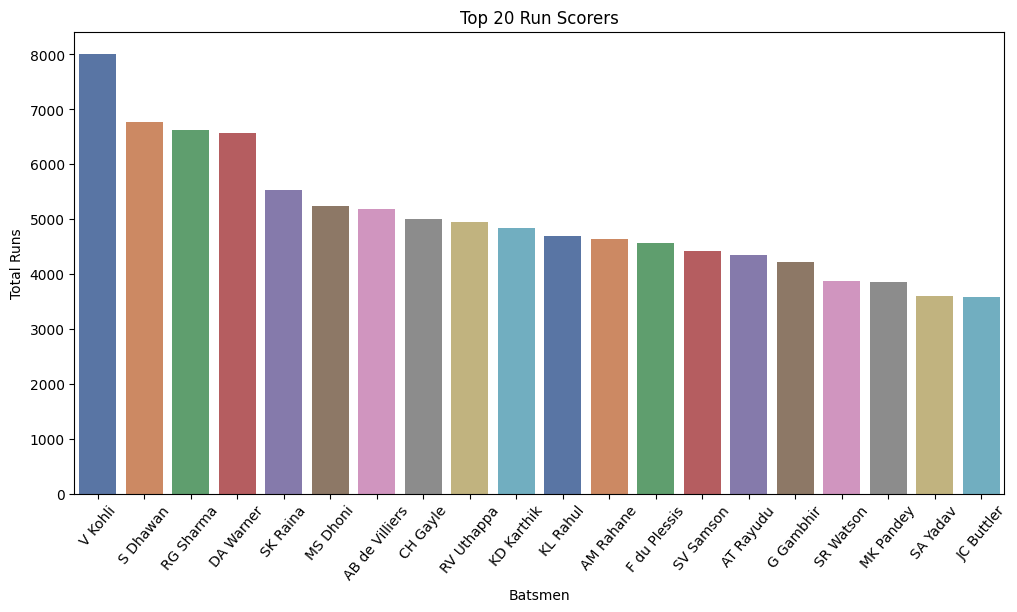

In [5]:
top_run_scorers = balls_df.groupby('batter')['batsman_runs'].sum().nlargest(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_run_scorers.index, y=top_run_scorers.values, palette='deep')
plt.xticks(rotation=50)
plt.xlabel('Batsmen')
plt.ylabel('Total Runs')
plt.title('Top 20 Run Scorers')
plt.show()

#### Batting Average vs Strike Rate

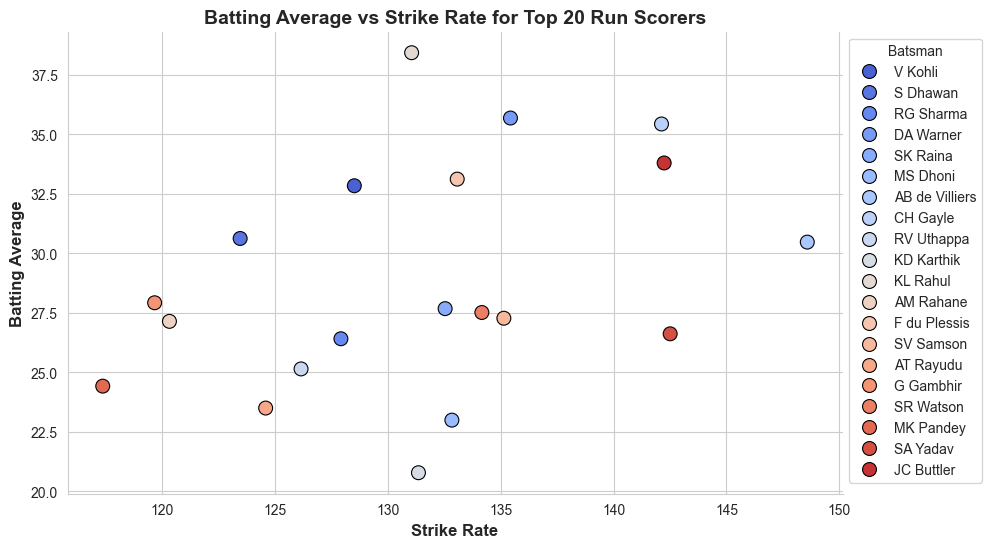

In [6]:

batting_stats = balls_df.groupby('batter').agg(
    Runs=('batsman_runs', 'sum'), 
    Balls_Faced=('ball', 'count'),
    Matches=('match_id', 'nunique')
)

batting_stats = batting_stats.loc[top_run_scorers.index]


batting_stats['Strike Rate'] = (batting_stats['Runs'] / batting_stats['Balls_Faced']) * 100
batting_stats['Batting Average'] = batting_stats['Runs'] / batting_stats['Matches']


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    x=batting_stats['Strike Rate'], 
    y=batting_stats['Batting Average'],  
    hue=batting_stats.index, 
    palette='coolwarm', 
    s=100, 
    edgecolor="black"
)

plt.xlabel('Strike Rate', fontsize=12, fontweight='bold')
plt.ylabel('Batting Average', fontsize=12, fontweight='bold')
plt.title('Batting Average vs Strike Rate for Top 20 Run Scorers', fontsize=14, fontweight='bold')

plt.legend(title='Batsman', bbox_to_anchor=(1, 1), fontsize=10)
sns.despine()

plt.show()


#### Top 10 Batsmen by Batting Average and Strike rate

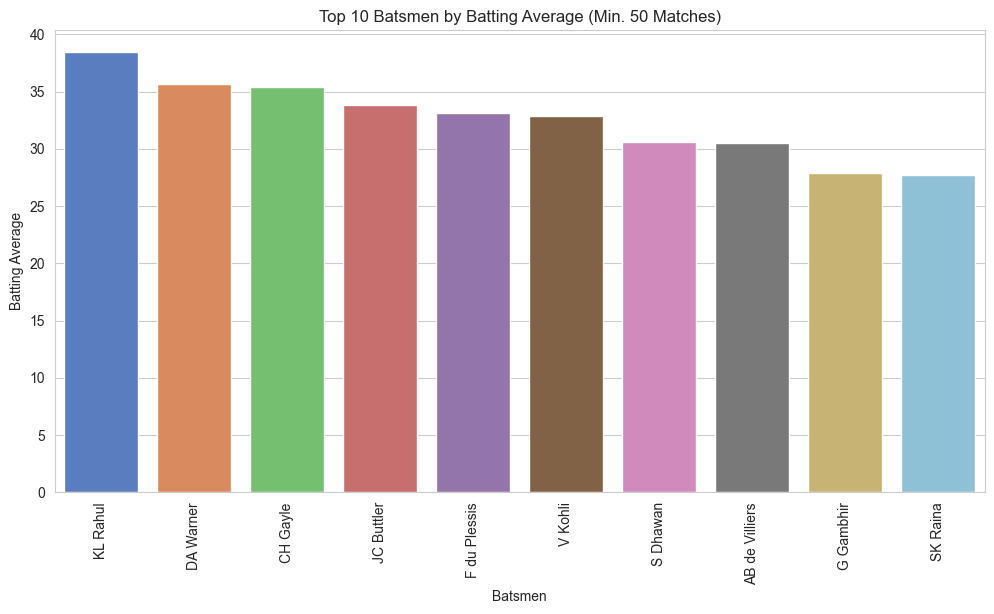

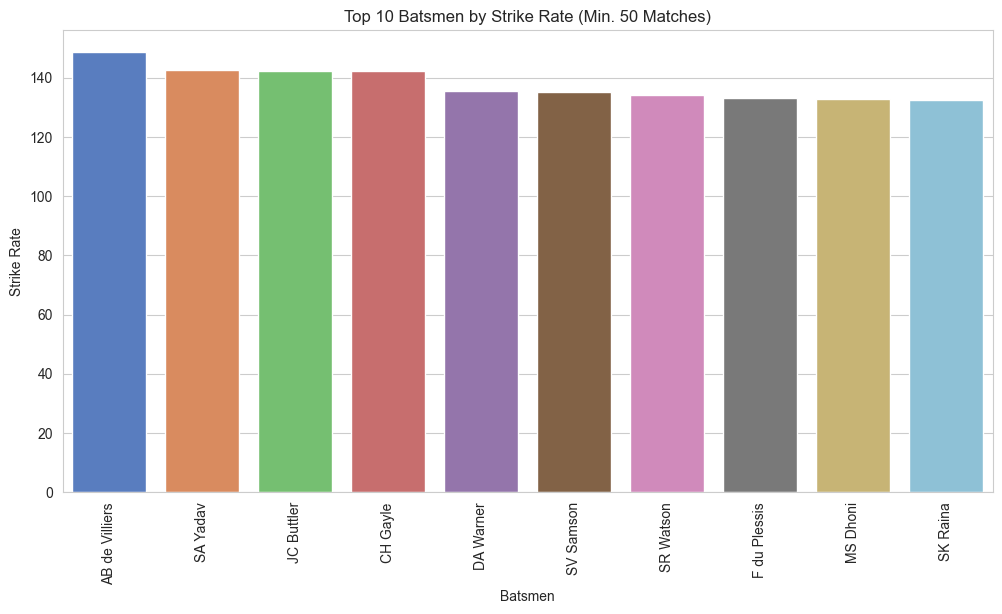

In [10]:
batting_stats['Matches'] = balls_df.groupby('batter')['match_id'].nunique()
filtered_batsmen = batting_stats[batting_stats['Matches'] > 50]
filtered_batsmen['Batting Average'] = filtered_batsmen['Runs'] / filtered_batsmen['Matches']


top_batting_average = filtered_batsmen.nlargest(10, 'Batting Average')


top_strike_rate = filtered_batsmen.nlargest(10, 'Strike Rate')




plt.figure(figsize=(12, 6))
sns.barplot(x=top_batting_average.index, y=top_batting_average['Batting Average'], palette='muted')
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Batting Average')
plt.title('Top 10 Batsmen by Batting Average (Min. 50 Matches)')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(x=top_strike_rate.index, y=top_strike_rate['Strike Rate'], palette='muted')
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Strike Rate')
plt.title('Top 10 Batsmen by Strike Rate (Min. 50 Matches)')
plt.show()

#### Top-10 Wicket-Takers

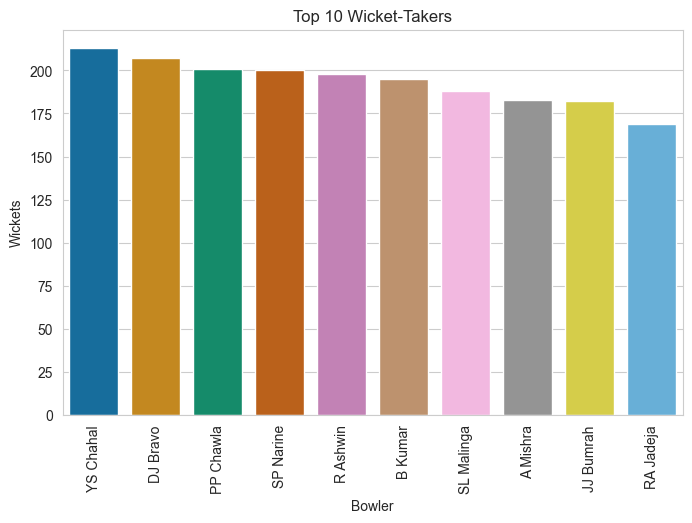

In [11]:
wicket_stats = balls_df[balls_df["is_wicket"] == 1].groupby("bowler").agg({"is_wicket": "sum"}).rename(columns={"is_wicket": "wickets"})
top_wicket_takers = wicket_stats.nlargest(10, "wickets")


plt.figure(figsize=(8,5))
sns.barplot(x=top_wicket_takers.index, y=top_wicket_takers["wickets"], palette="colorblind")
plt.xticks(rotation=90)
plt.title("Top 10 Wicket-Takers")
plt.xlabel("Bowler")
plt.ylabel("Wickets")
plt.show()

#### Top 10 Highest Individual Scores

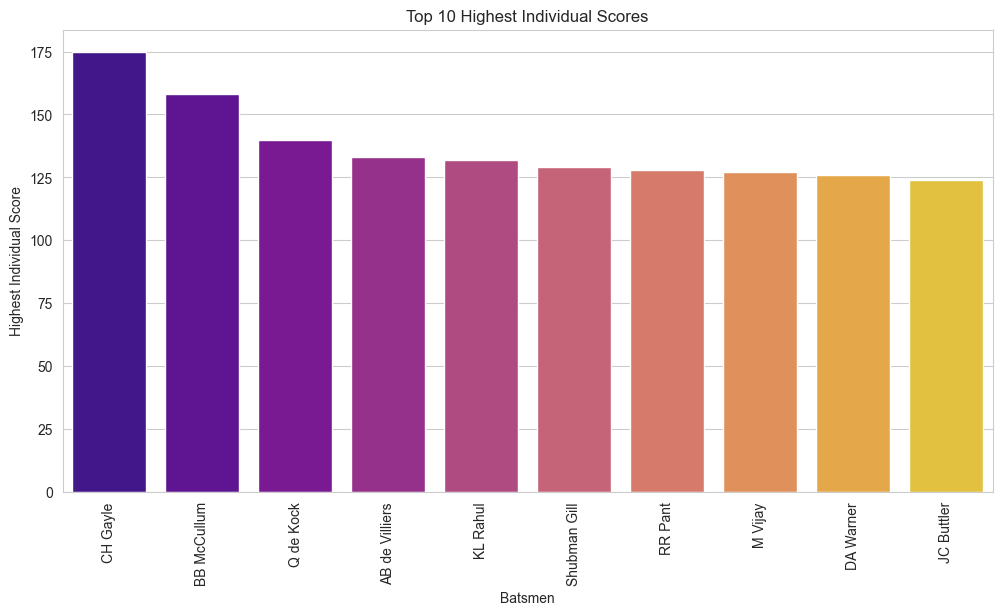

In [12]:

top_individual_scores = balls_df.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()

top_individual_scores = top_individual_scores.groupby('batter', as_index=False)['batsman_runs'].max()


top_individual_scores = top_individual_scores.nlargest(10, 'batsman_runs').sort_values(by='batsman_runs', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x=top_individual_scores['batter'], y=top_individual_scores['batsman_runs'], palette='plasma', ci=None)
plt.xticks(rotation=90)
plt.xlabel('Batsmen')
plt.ylabel('Highest Individual Score')
plt.title('Top 10 Highest Individual Scores')
plt.show()


#### Top 10 man of the Match winners

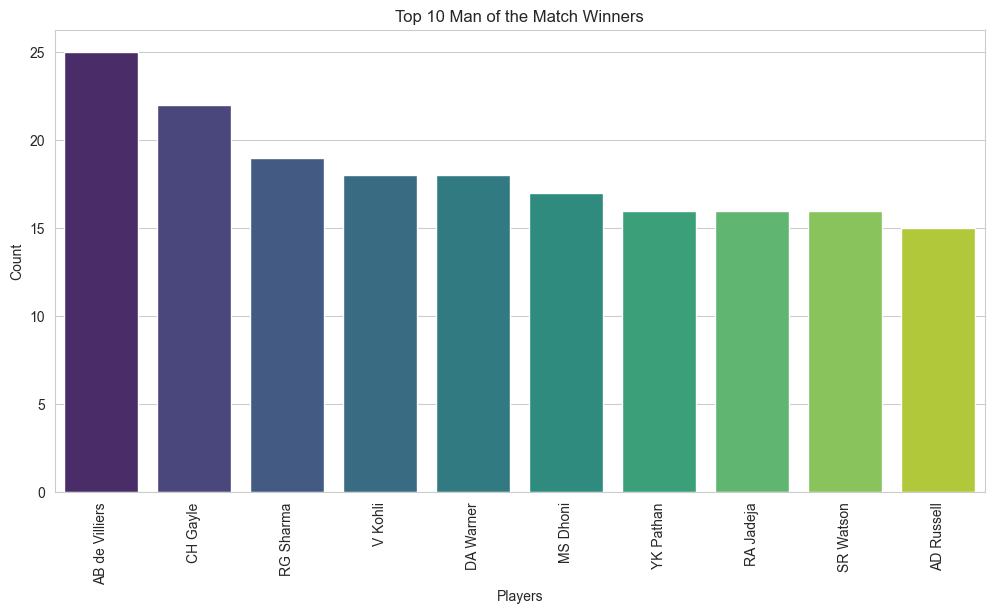

In [16]:
mom_counts = matches_df['player_of_match'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=mom_counts.index, y=mom_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Players')
plt.ylabel('Count')
plt.title('Top 10 Man of the Match Winners')
plt.show()

#### K-mean Clustering of Players

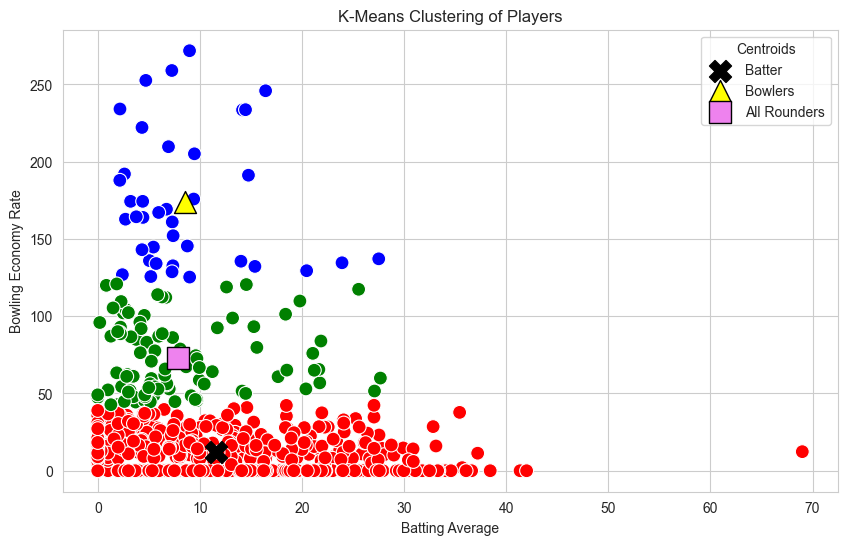

In [17]:
player_stats = balls_df.groupby('batter').agg({'batsman_runs': 'sum', 'ball': 'count'})
bowler_stats = balls_df.groupby('bowler').agg({'total_runs': 'sum', 'over': 'nunique'})
player_stats['Batting Average'] = player_stats['batsman_runs'] / balls_df.groupby('batter')['match_id'].nunique()
bowler_stats['Economy Rate'] = bowler_stats['total_runs'] / bowler_stats['over']
merged_stats = pd.merge(player_stats, bowler_stats, left_index=True, right_index=True, how='outer').fillna(0)

kmeans = KMeans(n_clusters=3, random_state=42).fit(merged_stats[['Batting Average', 'Economy Rate']])
merged_stats['Cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

cluster_colors = ['red', 'blue', 'green']
cluster_mark_colors = ['black', 'yellow', 'violet']
centroid_markers = ['X', '^', 's']
centroid_labels = ['Batter', 'Bowlers', 'All Rounders']


plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_stats['Batting Average'], y=merged_stats['Economy Rate'], hue=merged_stats['Cluster'], palette=cluster_colors, s=100)


centroid_handles = []
for i, (x, y) in enumerate(centroids):
    scatter = plt.scatter(x, y, c=cluster_mark_colors[i], marker=centroid_markers[i], s=250, edgecolors='black', label=centroid_labels[i])
    centroid_handles.append(scatter) 

plt.xlabel('Batting Average')
plt.ylabel('Bowling Economy Rate')
plt.title('K-Means Clustering of Players')

plt.legend(handles=centroid_handles, title="Centroids", loc='upper right')

plt.show()


#### Top 10 Batsmen with most 1s, 2s, 4s, 6s

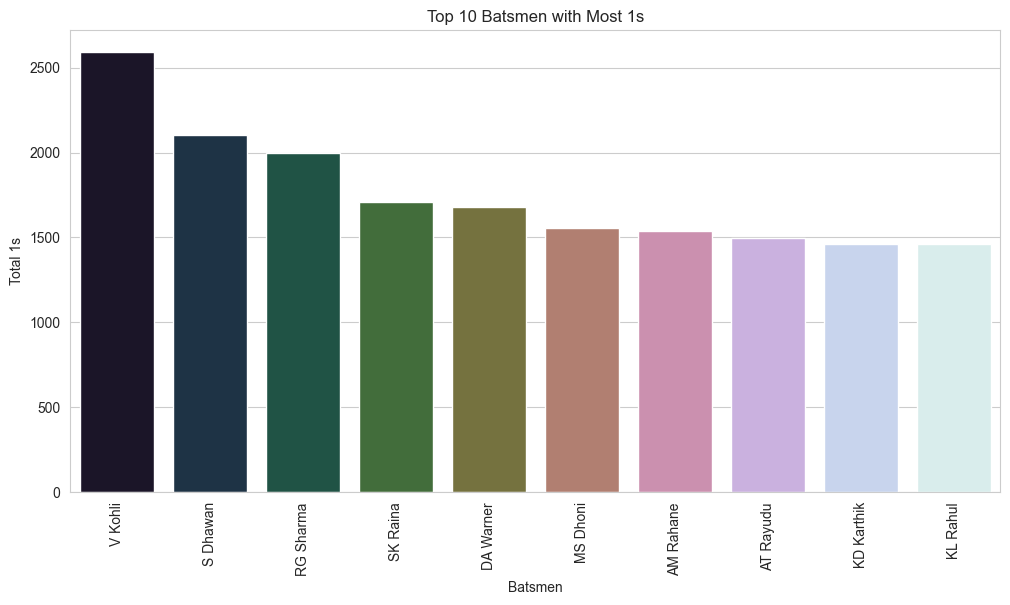

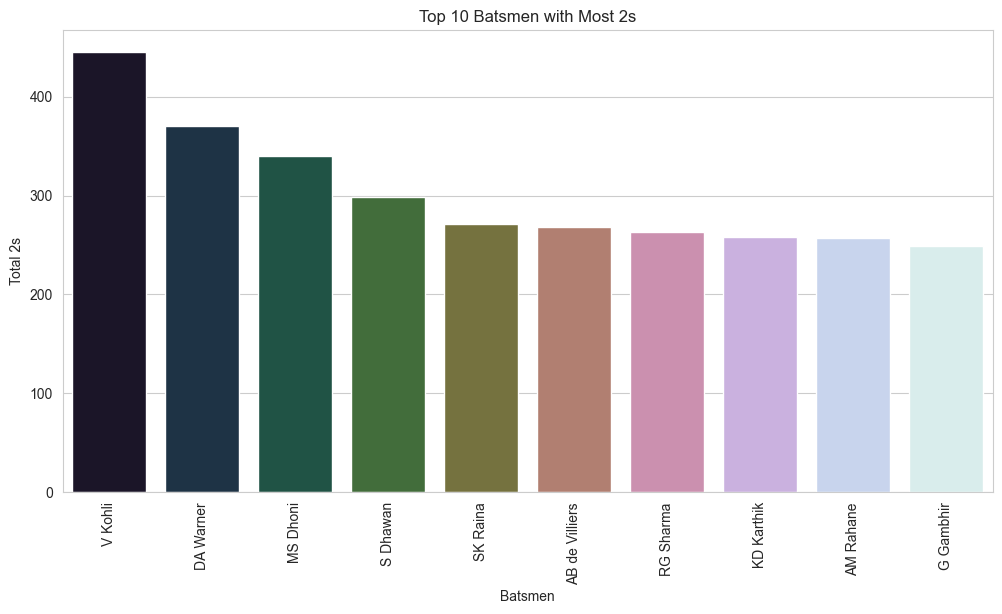

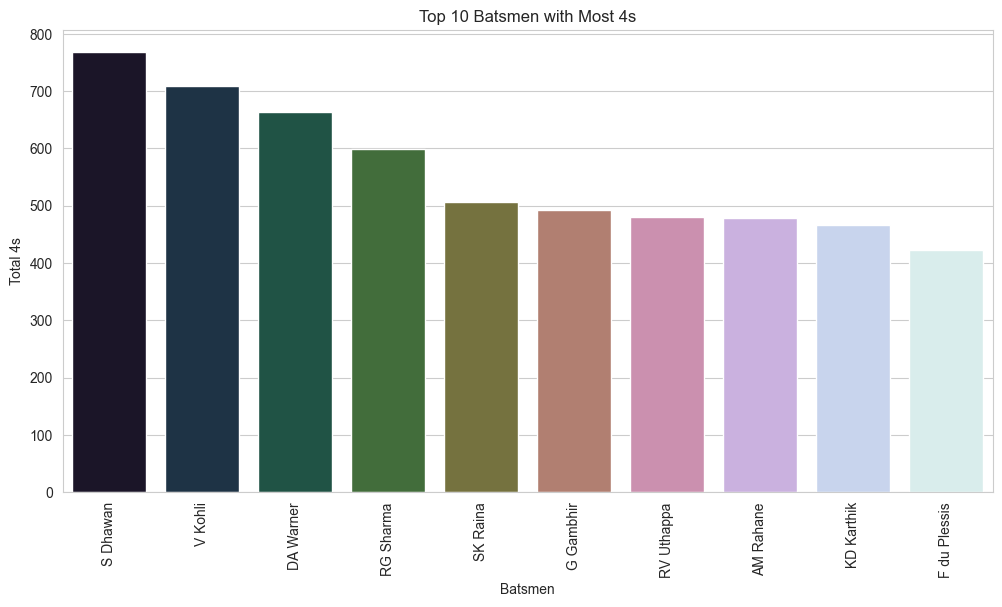

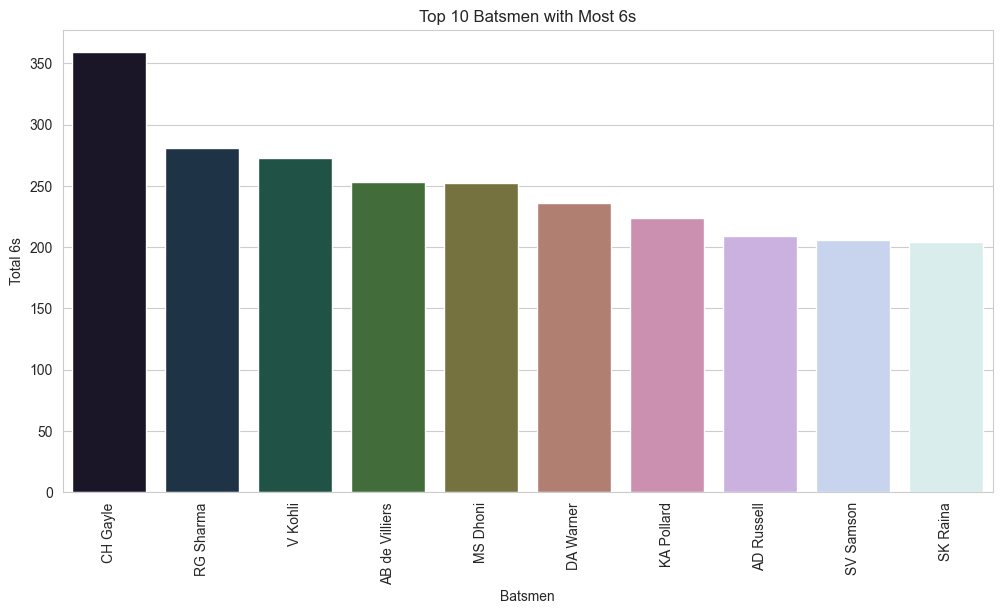

In [18]:
run_types = {1: '1s', 2: '2s', 4: '4s', 6: '6s'}
for run, label in run_types.items():
    top_scorers = balls_df[balls_df['batsman_runs'] == run].groupby('batter')['batsman_runs'].count().nlargest(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_scorers.index, y=top_scorers.values, palette='cubehelix')
    plt.xticks(rotation=90)
    plt.xlabel('Batsmen')
    plt.ylabel(f'Total {label}')
    plt.title(f'Top 10 Batsmen with Most {label}')
    plt.show()